# ENTREGA ENSEMBLE LEARNING

## Integrantes:

 + Jorge Peralta Fernández-Revuelta Lechuga

 + Alberto García Martín

 + Ignacio Urretavizcaya Tato

 + Juan López Segura

In [19]:
# EDA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


# Clustering

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.cluster.vq import vq
from sklearn.mixture import GaussianMixture

# Other
from mltools import unsupervised_tools as UT

# Predictions
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


## PASO 1: EDA

### 1. Lectura de Datos

In [2]:
nom_fi_datos_Irrad = "data/G10A_DATOS_IRRAD.csv"
df_orig_Irrad = pd.read_csv(nom_fi_datos_Irrad)

# parseamos la fecha (cadena) para que sea un datetime con formato yyyy/mm/dd

df_orig_Irrad['FECHA'] = pd.to_datetime(df_orig_Irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_Irrad.loc[:,'FECHA']
df_orig_Irrad['FECHA'] =  s.dt.date

In [3]:
nom_fi_datos_Util = "data/G10A_DATOS_UTIL.csv"
df_orig_Util = pd.read_csv(nom_fi_datos_Util)

df_orig_Util['FECHA'] = pd.to_datetime(df_orig_Util['FECHA'], format='%Y-%m-%d')

s = df_orig_Util.loc[:,'FECHA']
df_orig_Util['FECHA'] =  s.dt.date

El primero de los dos dataframes contiene datos de irradiación solar acumulada cada 3 horas (es decir, la irradaición solar del tramo de la hora 0 es la acumulada de las horas 0, 1 y 2, su suma). Se conoce como irradiación solar a la irradiación neta absorbida por la superficie terrestre, siendo ésta la suma de la radiación directa, difusa (a través de nubes) y reflejada (por ejemplo, reflejada del suelo).

Por otro lado tenemos los registros correspondientes de la utilización solar fotovoltaica, que se define como la generación solar horaria entre la potencia (por lo que es adimensional, y se encuentra entre 0 y 1). Además, la utilización horaria del tramo h no es la suma de las horas $h$, $h+1$ y $h+2$, sino su media.

In [4]:
# Unir los DataFrames en uno solo llamado df
df2 = pd.merge(df_orig_Irrad, df_orig_Util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'])

df2.head()

,FECHA,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,ANNO,...,DIA,DIASEM,UTILH00,UTILH03,UTILH06,UTILH09,UTILH12,UTILH15,UTILH18,UTILH21
0,2015-01-01,0.0,0.0,0.0,393513.78,1228750.1,598885.60,0.0,0.0,2015,...,1,3,0.0,0.0,0.032237,0.370669,0.468188,0.106079,0.00000,0.0
1,2015-01-02,0.0,0.0,0.0,338985.30,1155297.4,476027.28,0.0,0.0,2015,...,2,4,0.0,0.0,0.016250,0.282763,0.366319,0.071596,0.00000,0.0
2,2015-01-03,0.0,0.0,0.0,377949.56,1216140.1,551573.30,0.0,0.0,2015,...,3,5,0.0,0.0,0.018172,0.329772,0.429112,0.098794,0.00000,0.0
3,2015-01-04,0.0,0.0,0.0,363471.10,1230439.8,604020.10,0.0,0.0,2015,...,4,6,0.0,0.0,0.014853,0.265177,0.452586,0.107071,0.00000,0.0
4,2015-01-05,0.0,0.0,0.0,308257.75,1126382.5,544212.94,0.0,0.0,2015,...,5,0,0.0,0.0,0.015036,0.279424,0.354116,0.067873,0.00002,0.0


### 2. Valores Faltantes y Tipos de Variables

In [5]:
#Info and type of variables
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FECHA     2192 non-null   object 
 1   IRRADH00  2192 non-null   float64
 2   IRRADH03  2192 non-null   float64
 3   IRRADH06  2192 non-null   float64
 4   IRRADH09  2192 non-null   float64
 5   IRRADH12  2192 non-null   float64
 6   IRRADH15  2192 non-null   float64
 7   IRRADH18  2192 non-null   float64
 8   IRRADH21  2192 non-null   float64
 9   ANNO      2192 non-null   int64  
 10  MES       2192 non-null   int64  
 11  DIA       2192 non-null   int64  
 12  DIASEM    2192 non-null   int64  
 13  UTILH00   2192 non-null   float64
 14  UTILH03   2192 non-null   float64
 15  UTILH06   2192 non-null   float64
 16  UTILH09   2192 non-null   float64
 17  UTILH12   2192 non-null   float64
 18  UTILH15   2192 non-null   float64
 19  UTILH18   2192 non-null   float64
 20  UTILH21   2192 non-null   floa

No hay valores faltantes, y se encuentran con un formato correcto. No obstante, se cambian algunos formatos para que sea más cómoda su manipulación.

In [6]:
# Convertir las columnas 'ANNO', 'MES', 'DIA' y 'DIASEM' en categorías
df2['ANNO'] = df2['ANNO'].astype('category')
df2['MES'] = df2['MES'].astype('category')
df2['DIA'] = df2['DIA'].astype('category')
df2['DIASEM'] = df2['DIASEM'].astype('category')

In [7]:
#Info and type of variables
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FECHA     2192 non-null   object  
 1   IRRADH00  2192 non-null   float64 
 2   IRRADH03  2192 non-null   float64 
 3   IRRADH06  2192 non-null   float64 
 4   IRRADH09  2192 non-null   float64 
 5   IRRADH12  2192 non-null   float64 
 6   IRRADH15  2192 non-null   float64 
 7   IRRADH18  2192 non-null   float64 
 8   IRRADH21  2192 non-null   float64 
 9   ANNO      2192 non-null   category
 10  MES       2192 non-null   category
 11  DIA       2192 non-null   category
 12  DIASEM    2192 non-null   category
 13  UTILH00   2192 non-null   float64 
 14  UTILH03   2192 non-null   float64 
 15  UTILH06   2192 non-null   float64 
 16  UTILH09   2192 non-null   float64 
 17  UTILH12   2192 non-null   float64 
 18  UTILH15   2192 non-null   float64 
 19  UTILH18   2192 non-null   float64 
 20  UTILH21 

### 3. Búsqueda de Outliers

In [8]:
# Data describe
df2.describe()

,IRRADH00,IRRADH03,IRRADH06,IRRADH09,IRRADH12,IRRADH15,IRRADH18,IRRADH21,UTILH00,UTILH03,UTILH06,UTILH09,UTILH12,UTILH15,UTILH18,UTILH21
count,2192.0,2192.0,2192.000000,2.192000e+03,2.192000e+03,2.192000e+03,2192.000000,2192.0,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000
mean,0.0,0.0,94702.724066,1.101589e+06,1.716058e+06,1.089779e+06,133967.701842,0.0,0.000135,0.001774,0.093245,0.360505,0.414360,0.204008,0.012991,0.000098
std,0.0,0.0,148060.832994,6.771510e+05,8.377876e+05,6.809447e+05,199811.564332,0.0,0.000276,0.002380,0.079598,0.176818,0.187624,0.138319,0.018146,0.000196
min,0.0,0.0,0.000000,8.408046e+03,1.964414e+04,2.192887e+03,0.000000,0.0,0.000000,0.000000,0.000829,0.007645,0.008106,0.000682,0.000000,0.000000
25%,0.0,0.0,0.000000,4.461487e+05,1.051556e+06,4.936689e+05,0.000000,0.0,0.000000,0.000081,0.017445,0.212754,0.261524,0.076712,0.000040,0.000000
50%,0.0,0.0,0.000000,1.088099e+06,1.766789e+06,1.054568e+06,0.000000,0.0,0.000000,0.000826,0.077137,0.367105,0.441848,0.193826,0.001949,0.000000
75%,0.0,0.0,159331.900000,1.712944e+06,2.477452e+06,1.706886e+06,252328.225000,0.0,0.000188,0.002524,0.151881,0.518411,0.583739,0.329667,0.022359,0.000140
max,0.0,0.0,531755.500000,2.288140e+06,3.033988e+06,2.307160e+06,685027.800000,0.0,0.005681,0.016260,0.319156,0.695051,0.720680,0.474323,0.072435,0.004733


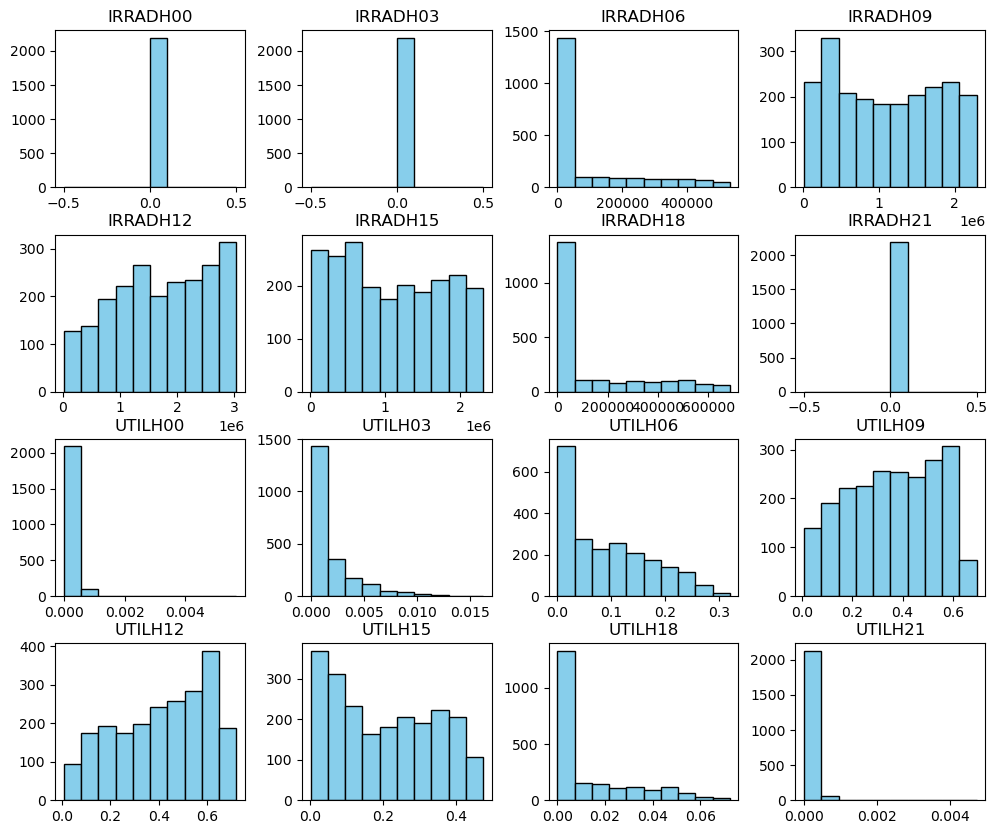

In [103]:
df2.hist(figsize=(12, 10), color='skyblue', edgecolor='black', grid=False)
plt.show()

In [104]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2192 entries, 0 to 2191
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   FECHA     2192 non-null   object  
 1   IRRADH00  2192 non-null   float64 
 2   IRRADH03  2192 non-null   float64 
 3   IRRADH06  2192 non-null   float64 
 4   IRRADH09  2192 non-null   float64 
 5   IRRADH12  2192 non-null   float64 
 6   IRRADH15  2192 non-null   float64 
 7   IRRADH18  2192 non-null   float64 
 8   IRRADH21  2192 non-null   float64 
 9   ANNO      2192 non-null   category
 10  MES       2192 non-null   category
 11  DIA       2192 non-null   category
 12  DIASEM    2192 non-null   category
 13  UTILH00   2192 non-null   float64 
 14  UTILH03   2192 non-null   float64 
 15  UTILH06   2192 non-null   float64 
 16  UTILH09   2192 non-null   float64 
 17  UTILH12   2192 non-null   float64 
 18  UTILH15   2192 non-null   float64 
 19  UTILH18   2192 non-null   float64 
 20  UTILH21 

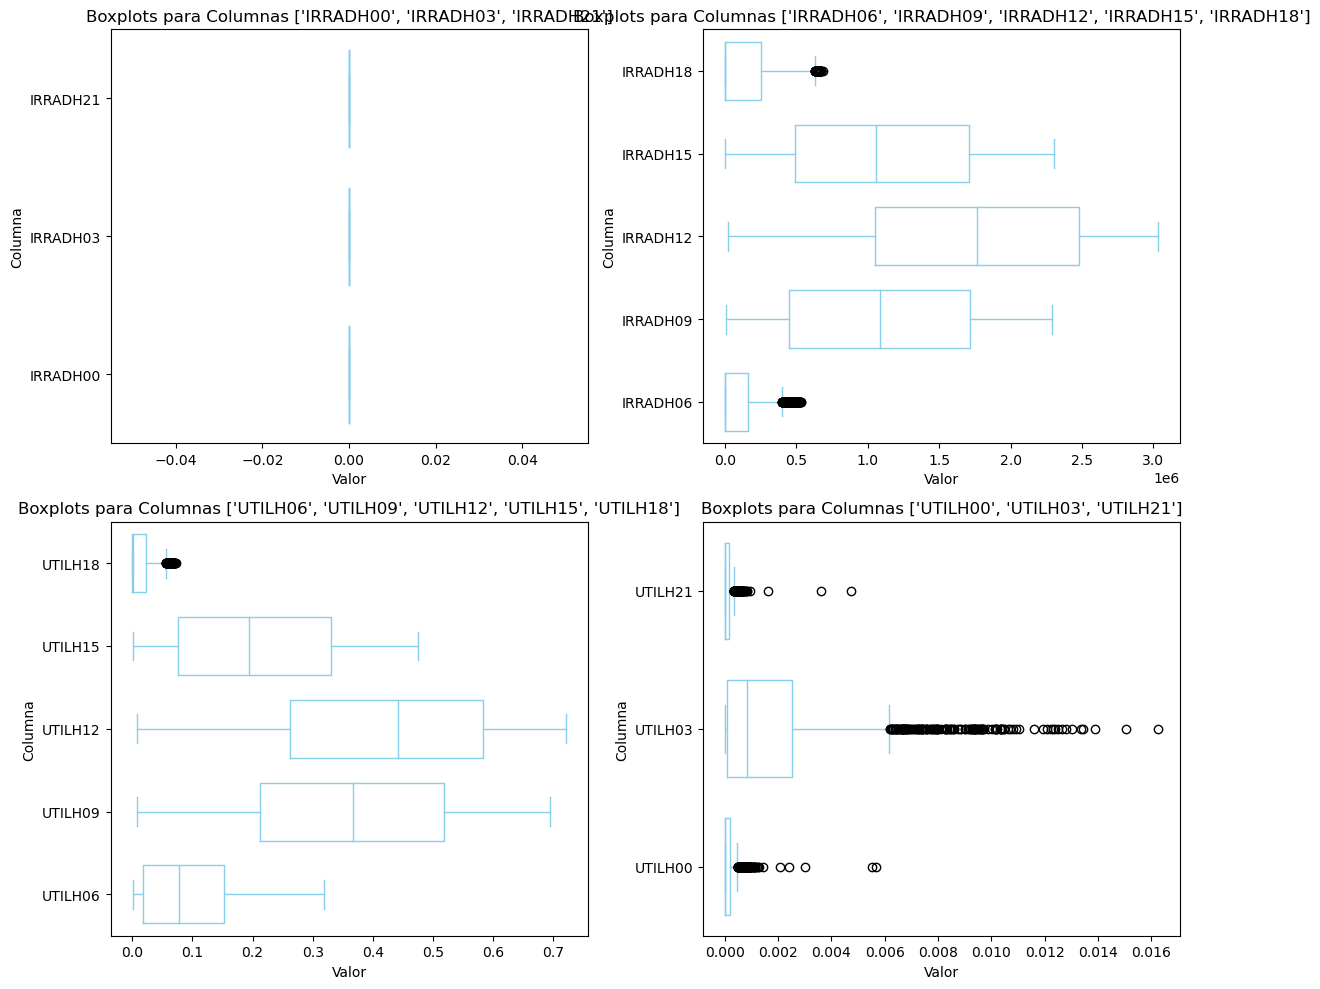

In [105]:
grupos_boxplot = [['IRRADH00', 'IRRADH03', 'IRRADH21'], ['IRRADH06', 'IRRADH09', 'IRRADH12', 'IRRADH15', 'IRRADH18'], 
                  ['UTILH06', 'UTILH09', 'UTILH12', 'UTILH15', 'UTILH18'], ['UTILH00', 'UTILH03', 'UTILH21']]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i in range(2):
    for j in range(2):
        grupo = grupos_boxplot[i * 2 + j]
        df_box = df2.loc[:, grupo]
        df_box.boxplot(ax=axes[i, j], grid=False, vert=False, color='skyblue', widths=0.7)
        axes[i, j].set_title(f'Boxplots para Columnas {grupo}')
        axes[i, j].set_ylabel('Columna')
        axes[i, j].set_xlabel('Valor')

plt.tight_layout()
plt.show()


No hay outliers claros. Como era de esperar, por las noches los valores son 0 (o prácticamente 0 en el caso de las utilizaciones horarias), y durante el día la distribución es similar para una agrupación horaria determinada tanto para la irradiación como para la utilización. Se podrían plantear transformaciones boxcox para buscar más normalidad en los datos, pero a priori no parece necesario.

También se comprueba que los valores de utilización están normalizados, tal y como establece su definición.

Quizás los únicos que llaman la atención son esos valores de utilización extrañamente altos para no haber irradiación (aunque siguen siendo muy bajos en comparación a los valores para las horas diurnas).

In [106]:
# Filtrar el DataFrame para incluir solo las columnas categóricas y la fecha
columnas_nonum = df2.select_dtypes(include=['category', 'object'])

# Obtener un resumen de información de las variables categóricas
columnas_nonum.describe()

,FECHA,ANNO,MES,DIA,DIASEM
count,2192,2192,2192,2192,2192
unique,2192,6,12,31,7
top,2015-01-01,2016,1,1,3
freq,1,366,186,72,314


In [107]:
columnas_categoricas = df2.select_dtypes(include=['category'])

cabeceras = columnas_categoricas.columns.tolist()

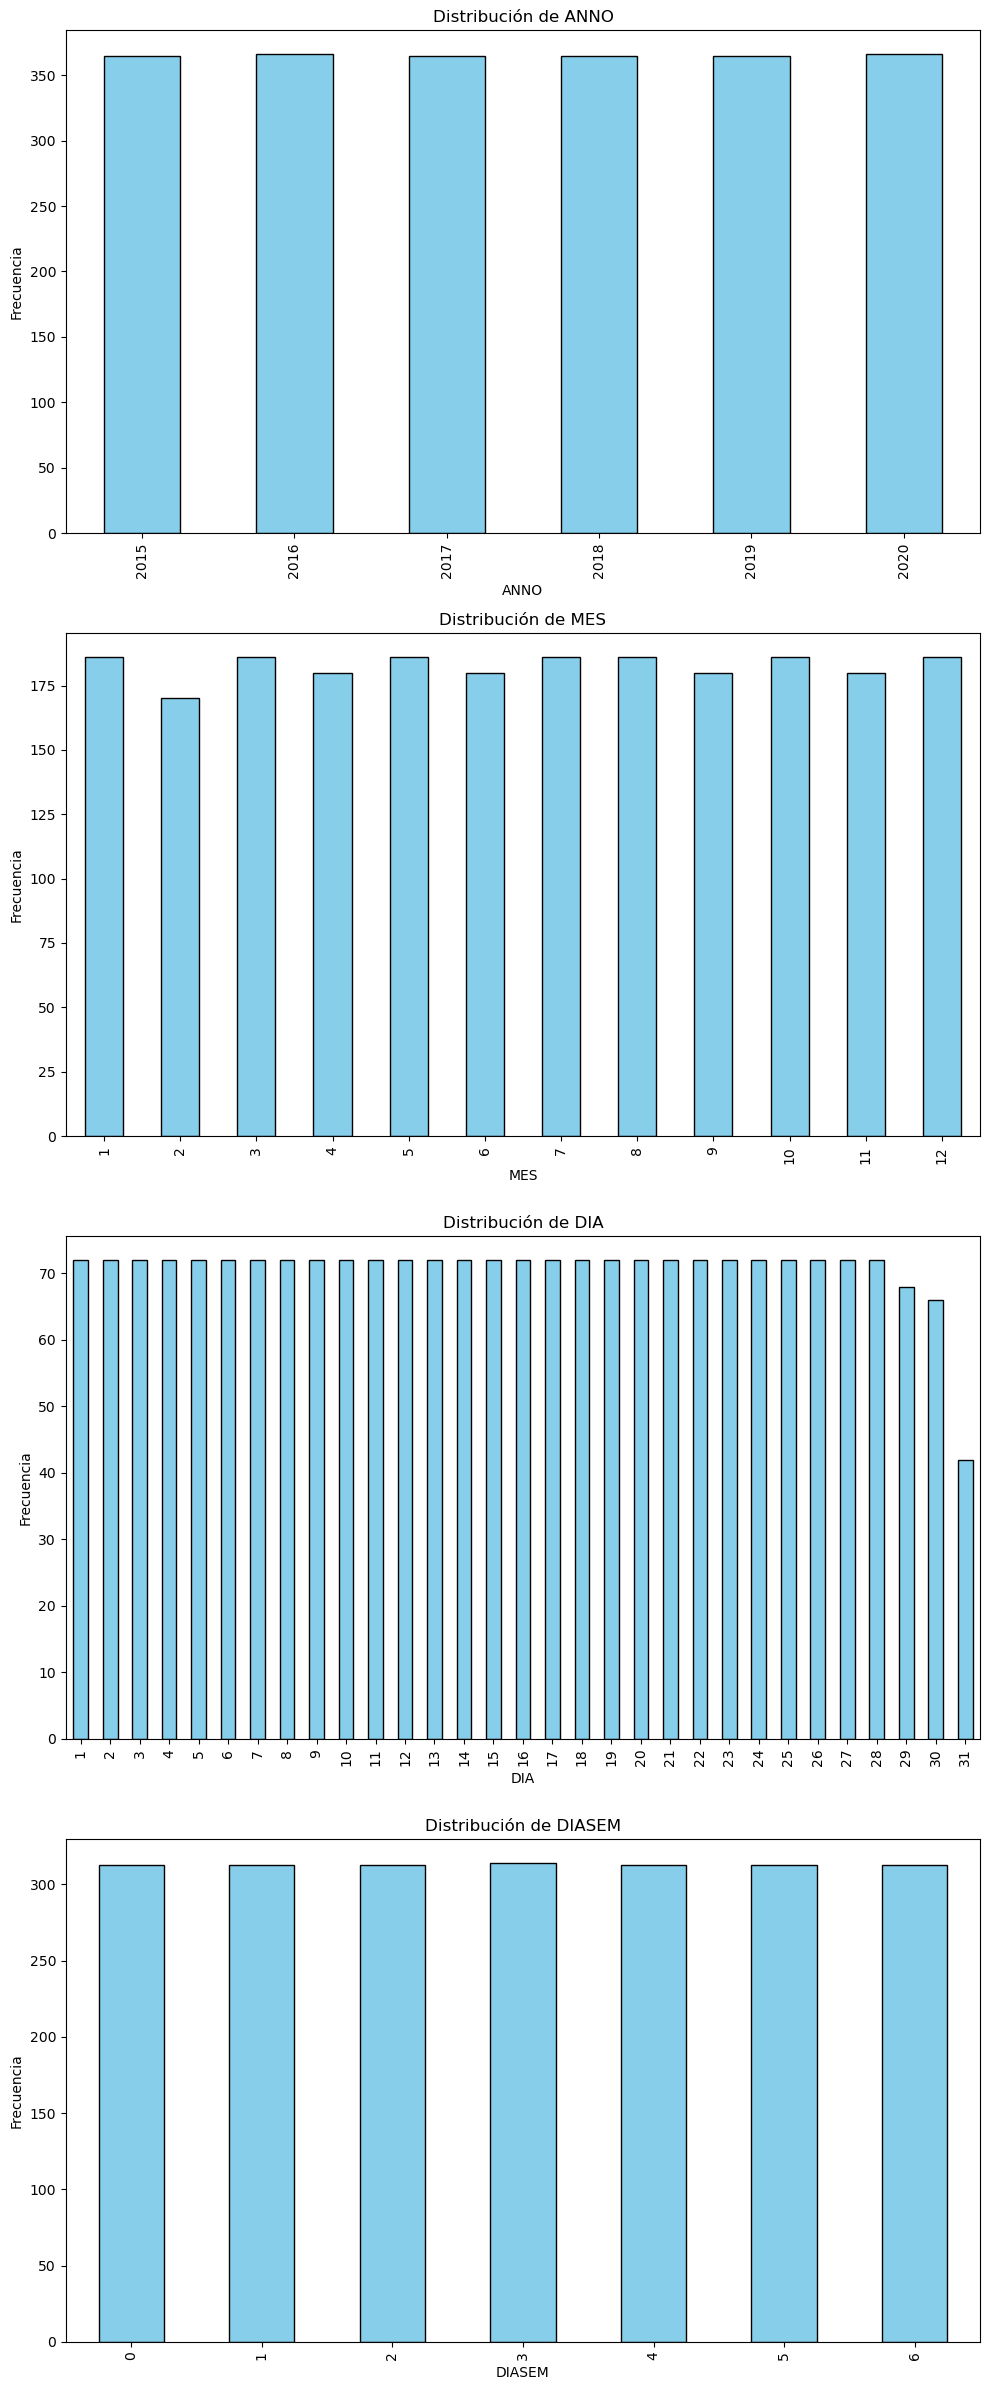

In [108]:
fig, axes = plt.subplots(len(cabeceras), 1, figsize=(10, 6*len(cabeceras)))

for i, var in enumerate(cabeceras):
    # Obtener recuentos de valores ordenados
    value_counts_sorted = df2[var].value_counts().sort_index()
    
    # Trazar el gráfico con los valores ordenados
    value_counts_sorted.plot(kind='bar', ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Las variables categóricas tampoco muestran un comportamiento anómalo.

Haciendo esta primera exploración, y sabiendo que se busca predecir el valor de la utilización horaria en función de la irradiación y el resto de predictores, aparece la necesidad de formatear nuestro conjunto de datos para que sea más cómodo y fácil de tratar. Además, es lógico no poder usar como predictor la irradiación de un grupo horario determinado para una utilización de un grupo horario anterior. Por ello, sse crea un predictor llamado grupo horario, y se juntan las 8 variables de irradiación y utilización en 1 única para cada una.

In [9]:
# Crear una lista para almacenar los datos
data = []

# Suponiendo que tienes un DataFrame llamado df con la estructura dada

# Iterar sobre cada día en el DataFrame original
for idx, row in df2.iterrows():
    fecha = row['FECHA']
    anno = row['ANNO']
    mes = row['MES']
    dia = row['DIA']
    diasem = row['DIASEM']
    
    # Iterar sobre cada grupo horario en el día
    for hora in range(0, 24, 3):
        grupo = hora // 3 * 3
        irradiancia = row[f'IRRADH{hora:02d}']
        utilidad = row[f'UTILH{hora:02d}']
        
        # Agregar los datos a la lista
        data.append([fecha, anno, mes, dia, diasem, grupo, irradiancia, utilidad])

# Crear el DataFrame a partir de la lista de datos
df = pd.DataFrame(data, columns=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH', 'IRRAD', 'UTIL'])

# Visualizar el nuevo DataFrame
print(df.head())

        FECHA  ANNO  MES  DIA  DIASEM  GH       IRRAD      UTIL
0  2015-01-01  2015    1    1       3   0        0.00  0.000000
1  2015-01-01  2015    1    1       3   3        0.00  0.000000
2  2015-01-01  2015    1    1       3   6        0.00  0.032237
3  2015-01-01  2015    1    1       3   9   393513.78  0.370669
4  2015-01-01  2015    1    1       3  12  1228750.10  0.468188


In [10]:
# Data describe
df.describe()

,ANNO,MES,DIA,DIASEM,GH,IRRAD,UTIL
count,17536.000000,17536.000000,17536.000000,17536.000000,17536.00000,1.753600e+04,17536.000000
mean,2017.500456,6.521898,15.732664,3.000000,10.50000,5.170120e+05,0.135889
std,1.708230,3.449085,8.801621,1.999601,6.87406,7.842147e+05,0.192569
min,2015.000000,1.000000,1.000000,0.000000,0.00000,0.000000e+00,0.000000
25%,2016.000000,4.000000,8.000000,1.000000,5.25000,0.000000e+00,0.000121
50%,2017.500000,7.000000,16.000000,3.000000,10.50000,0.000000e+00,0.016260
75%,2019.000000,10.000000,23.000000,5.000000,15.75000,8.223137e+05,0.233782
max,2020.000000,12.000000,31.000000,6.000000,21.00000,3.033988e+06,0.720680


Repetimos brevemente los pasos para el nuevo dataframe, comprobando que todo sea correcto y no haya comportamientos anómalos.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   17536 non-null  object 
 1   ANNO    17536 non-null  int64  
 2   MES     17536 non-null  int64  
 3   DIA     17536 non-null  int64  
 4   DIASEM  17536 non-null  int64  
 5   GH      17536 non-null  int64  
 6   IRRAD   17536 non-null  float64
 7   UTIL    17536 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 1.1+ MB


In [12]:
# Convertir las columnas en categorías
df['ANNO'] = df['ANNO'].astype('category')
df['MES'] = df['MES'].astype('category')
df['DIA'] = df['DIA'].astype('category')
df['DIASEM'] = df['DIASEM'].astype('category')
df['GH'] = df['GH'].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   FECHA   17536 non-null  object  
 1   ANNO    17536 non-null  category
 2   MES     17536 non-null  category
 3   DIA     17536 non-null  category
 4   DIASEM  17536 non-null  category
 5   GH      17536 non-null  category
 6   IRRAD   17536 non-null  float64 
 7   UTIL    17536 non-null  float64 
dtypes: category(5), float64(2), object(1)
memory usage: 499.3+ KB


<Axes: xlabel='IRRAD', ylabel='Count'>

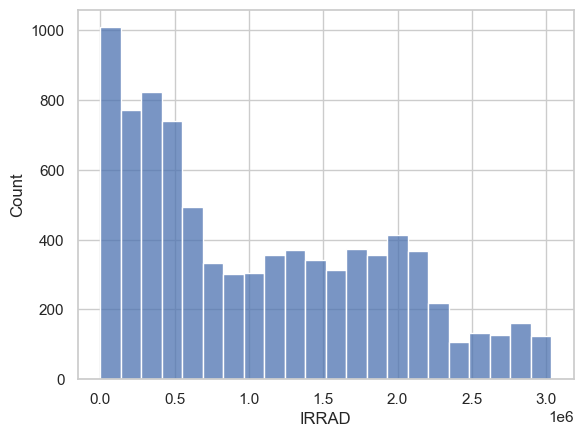

In [125]:
# Histograma para la variable IRRAD sin valores iguales a 0
sns.histplot(data=df[df['IRRAD'] != 0], x='IRRAD')

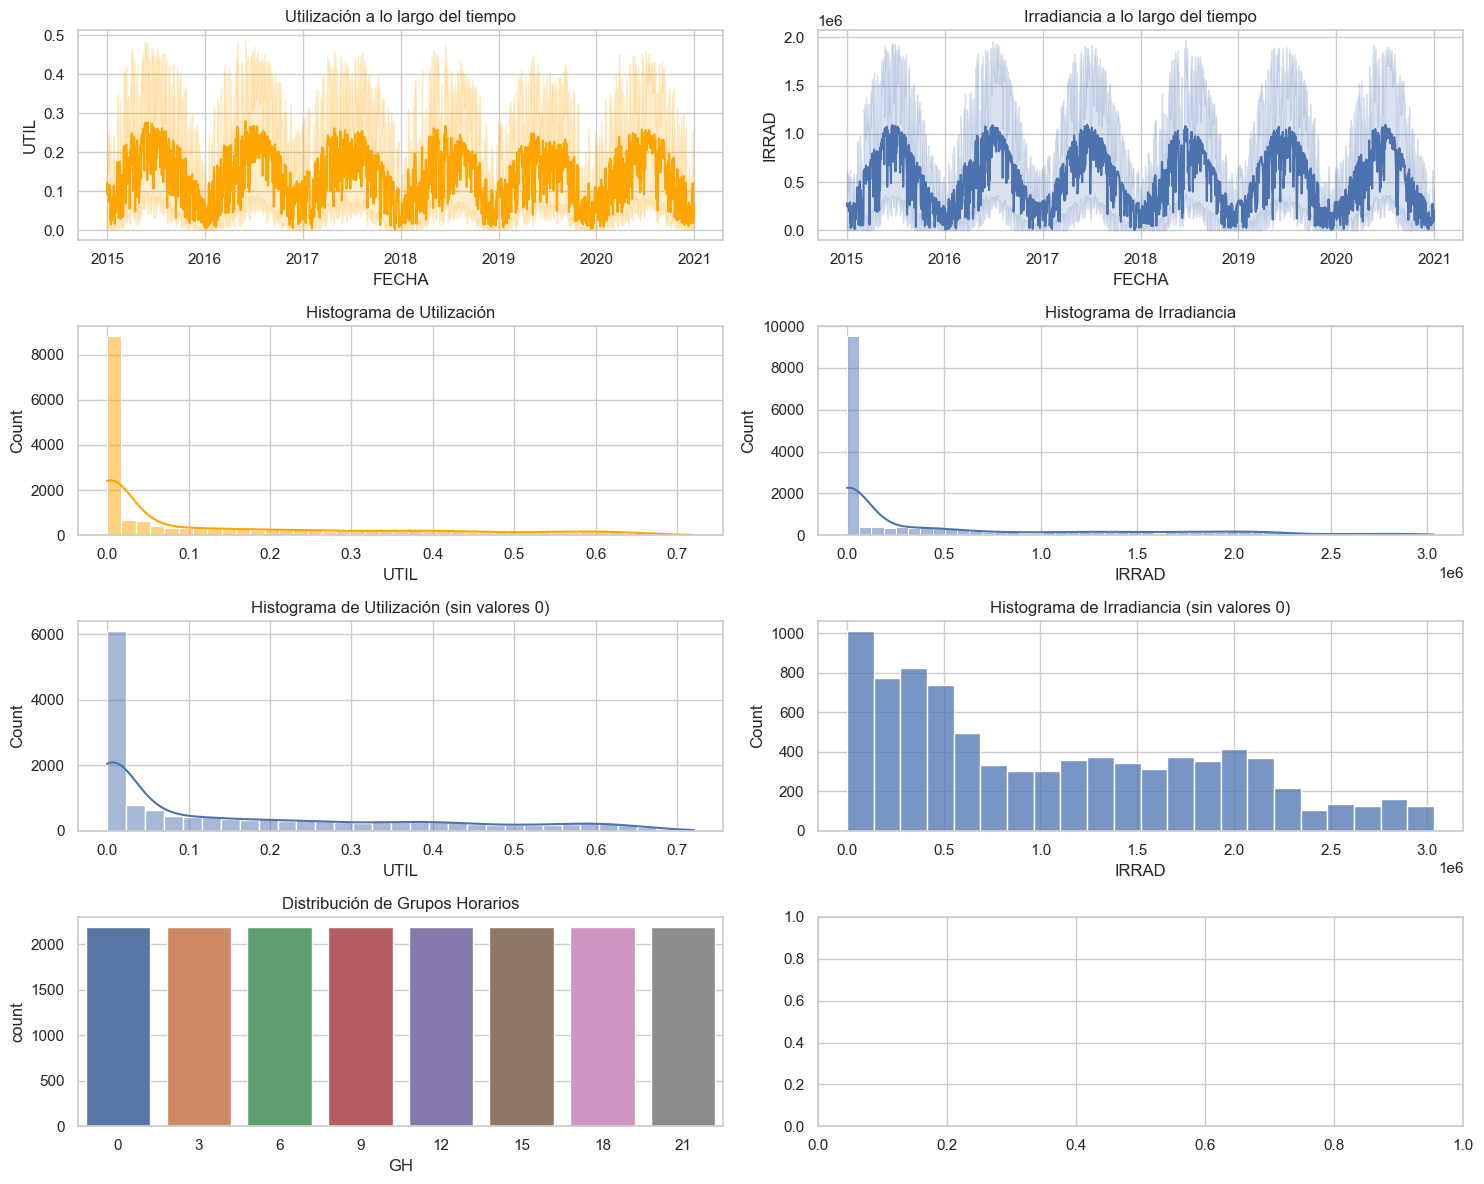

In [126]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear un nuevo conjunto de ejes (subplots)
fig, axs = plt.subplots(4, 2, figsize=(15, 12))


# Gráfico de línea temporal para la variable IRRAD
sns.lineplot(data=df, x='FECHA', y='IRRAD', ax=axs[0, 1])
axs[0, 1].set_title('Irradiancia a lo largo del tiempo')

# Histograma para la variable IRRAD
sns.histplot(data=df, x='IRRAD', ax=axs[1, 1], kde=True)
axs[1, 1].set_title('Histograma de Irradiancia')

# Histograma para la variable IRRAD sin valores iguales a 0
sns.histplot(data=df[df['IRRAD'] != 0], x='IRRAD', ax=axs[2, 1])
axs[2, 1].set_title('Histograma de Irradiancia (sin valores 0)')

# Gráfico de línea temporal para la variable UTIL
sns.lineplot(data=df, x='FECHA', y='UTIL', ax=axs[0, 0], color='orange')
axs[0, 0].set_title('Utilización a lo largo del tiempo')

# Histograma para la variable UTIL
sns.histplot(data=df, x='UTIL', ax=axs[1, 0], kde=True, color='orange')
axs[1, 0].set_title('Histograma de Utilización')

# Histograma para la variable UTIL sin valores iguales o muy cercanos a 0
sns.histplot(data=df[df['UTIL'] > 0.01], x='UTIL', ax=axs[2, 0], kde=True)
axs[2, 0].set_title('Histograma de Utilización (sin valores 0)')


# Gráfico de barras para los grupos horarios
sns.countplot(data=df, x='GH', ax=axs[3, 0])
axs[3, 0].set_title('Distribución de Grupos Horarios')

# Eliminar el espacio en blanco entre los subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

En efecto, el comportamiento es el esperado, por lo que se continúa con la siguiente etapa del EDA.

### 4. Análisis Exploratorio

Se comienza viendo un gráfico conjunto de relaciones entre todos los pares de variables.

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


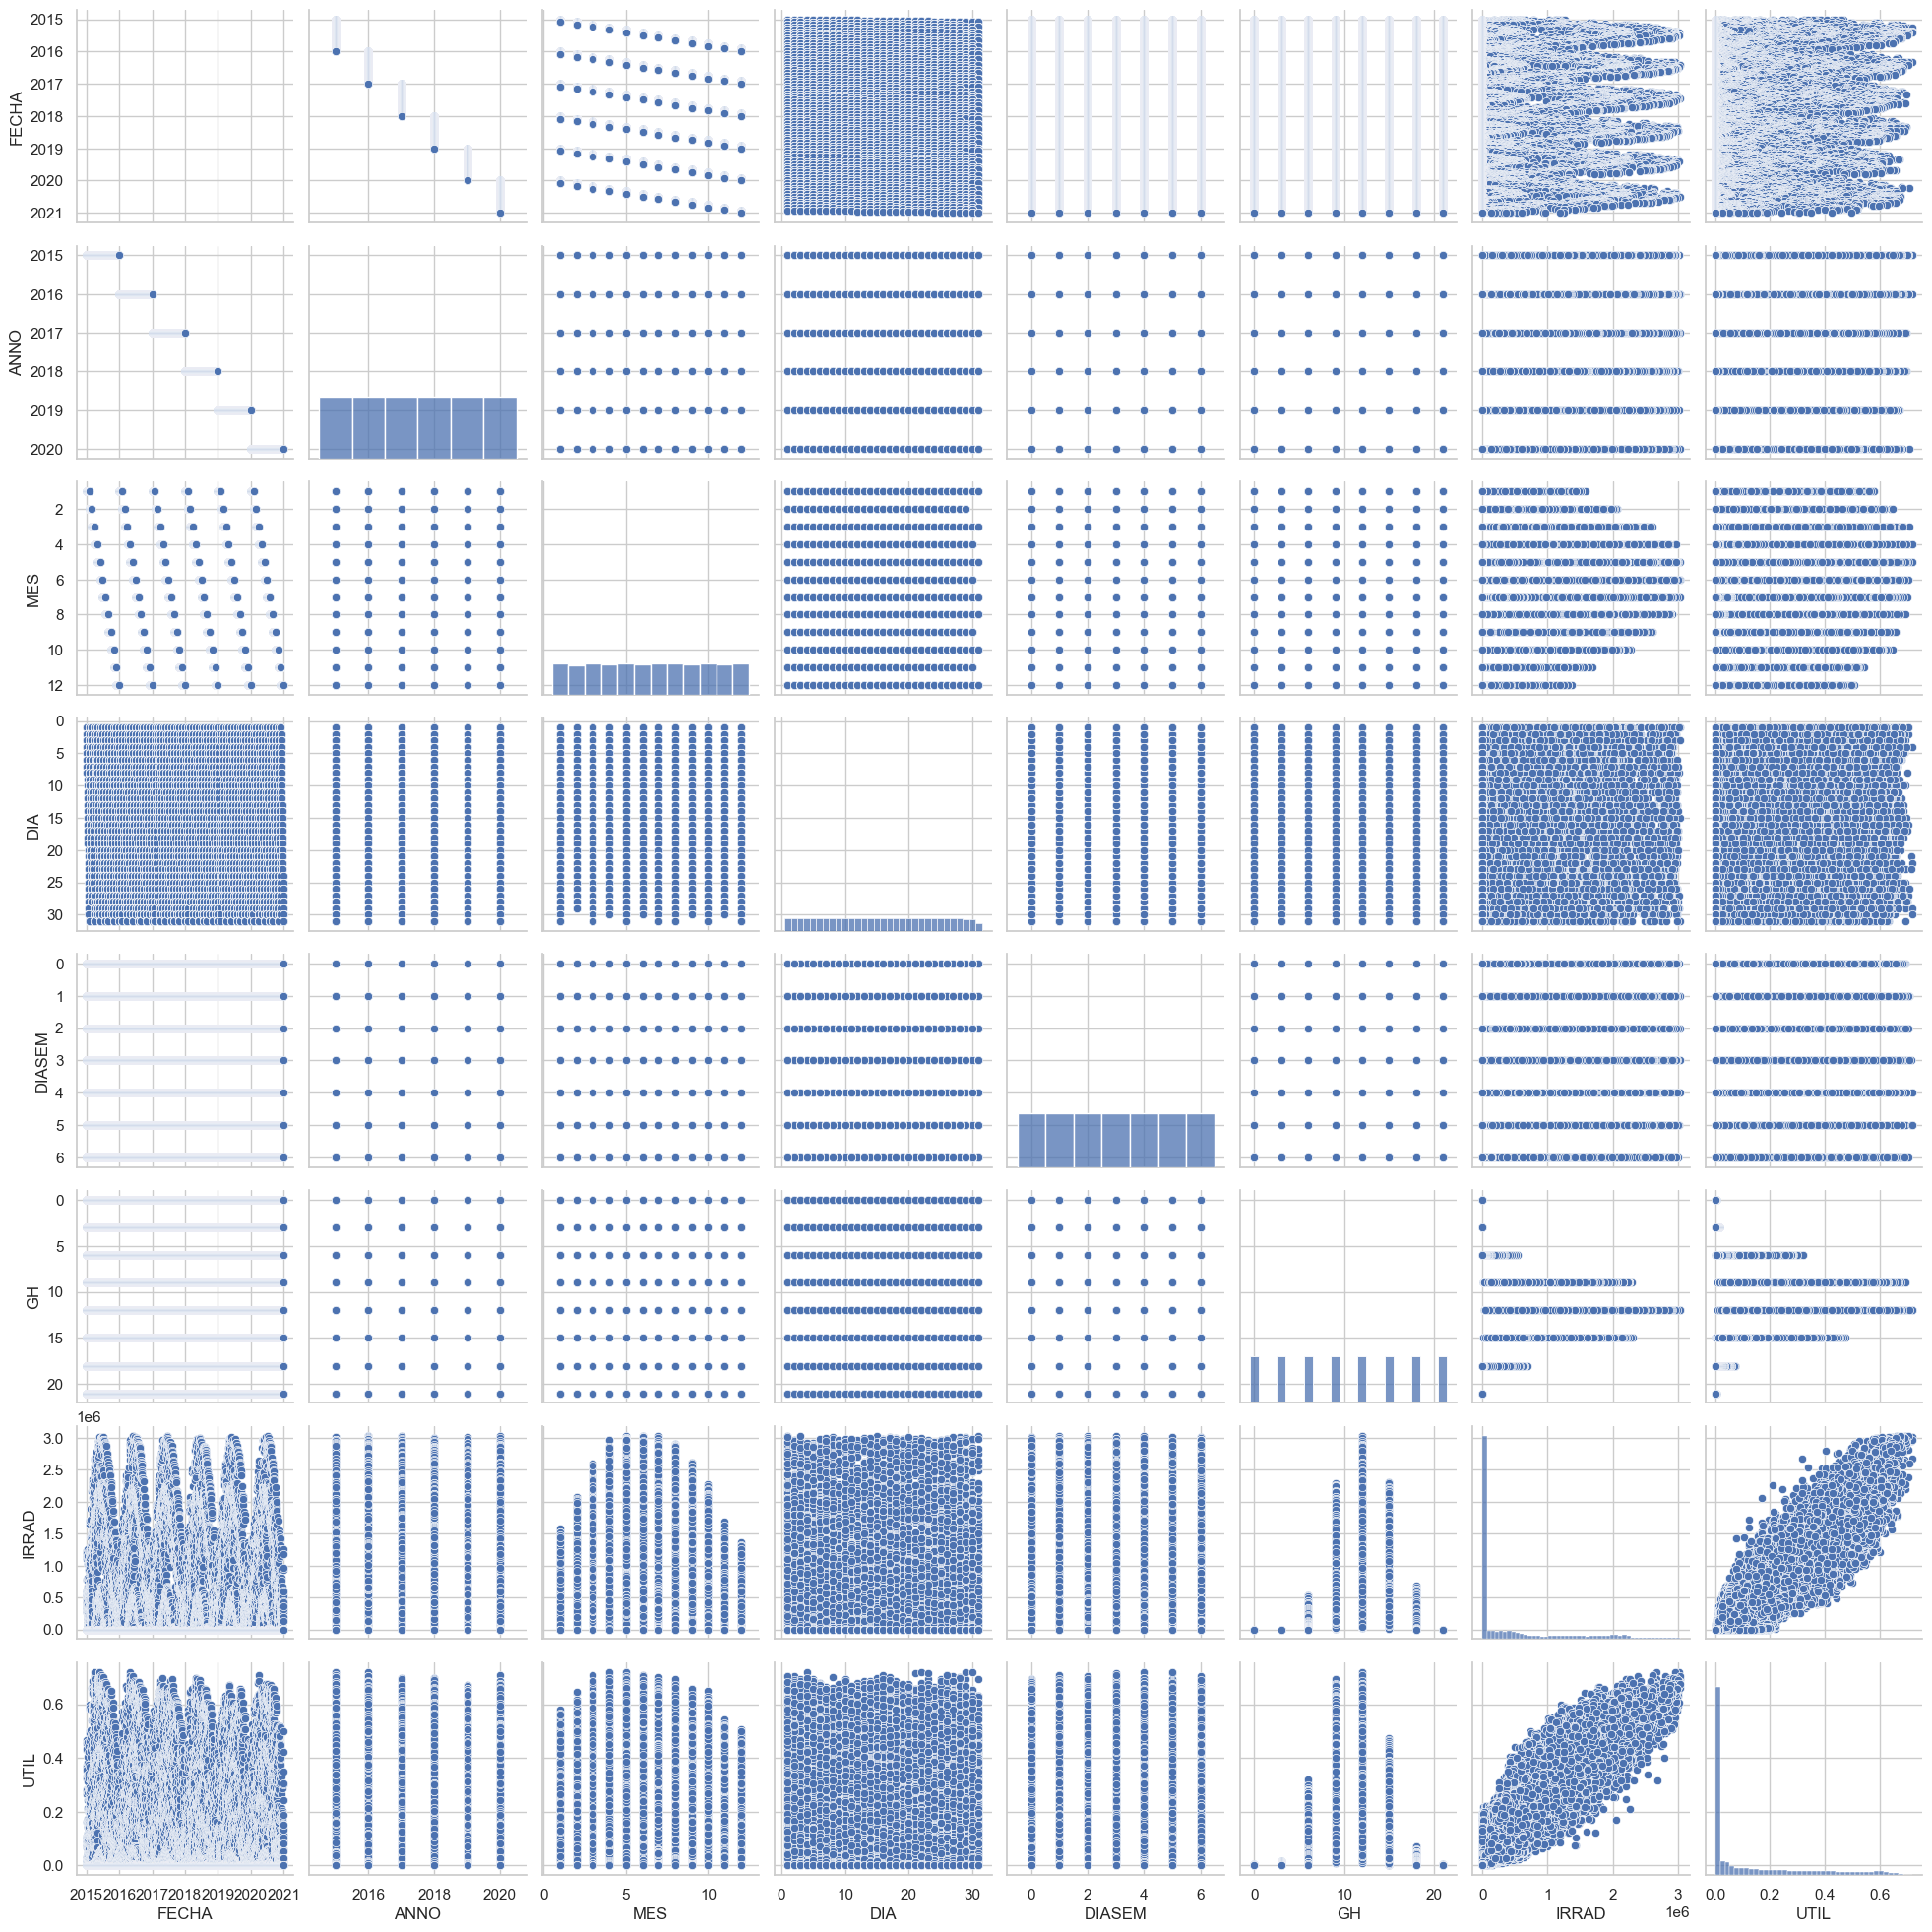

In [127]:
# Trazar el pairplot con las variables 
sns.pairplot(df, vars=df.columns.values.tolist())
plt.show()

Como era de esperar, tanto la irradiación como la utilización siguen patrones similares, donde principalmente afecta la fecha (en concreto, el mes), y el grupo horario. Además, ambas se relacionan de forma lineal. De nuevo, el comportamiento es generalmente el esperado.

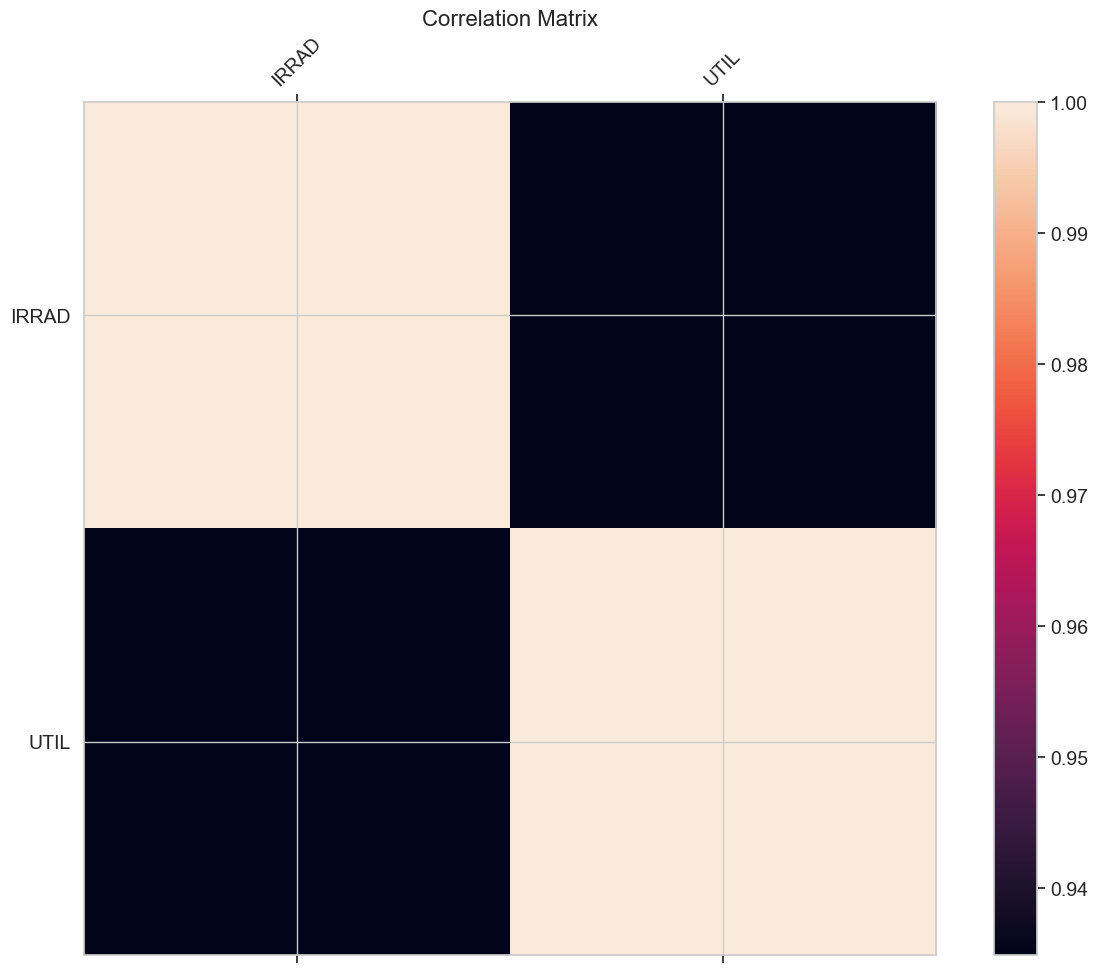

In [128]:
#correlation plot of numeric variables
f = plt.figure(figsize=(15, 11))
plt.matshow(df.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

Las correlaciones son las ya esperadas y comentadas anteriormente. Para los valores de irradiación nulos no aplica, ya que son siempre 0.

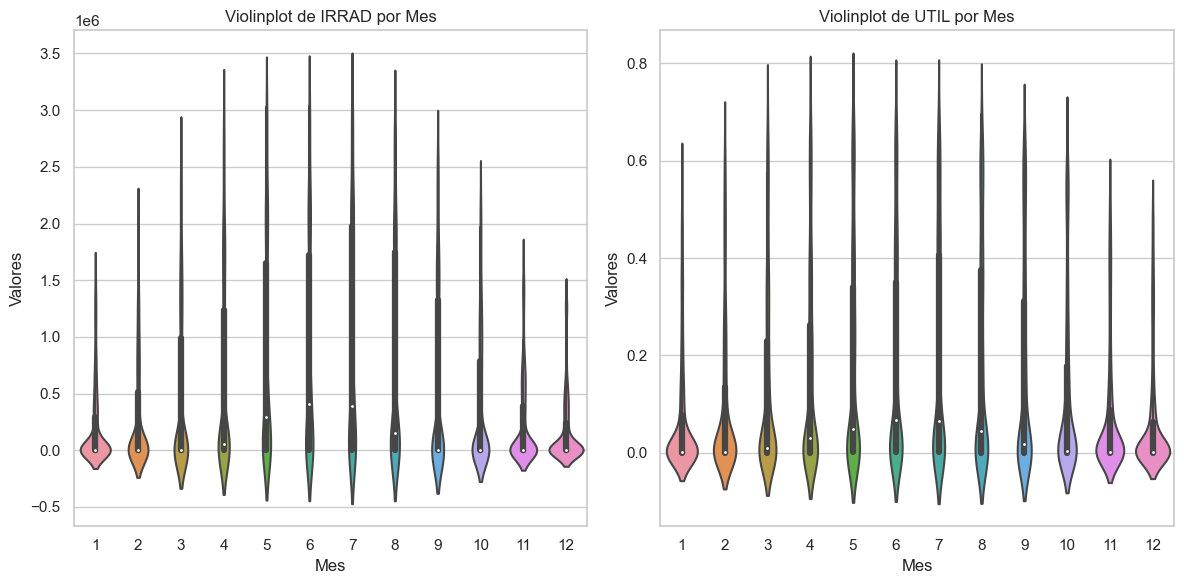

In [142]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='MES', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Mes')
    axs[col].set_xlabel('Mes')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

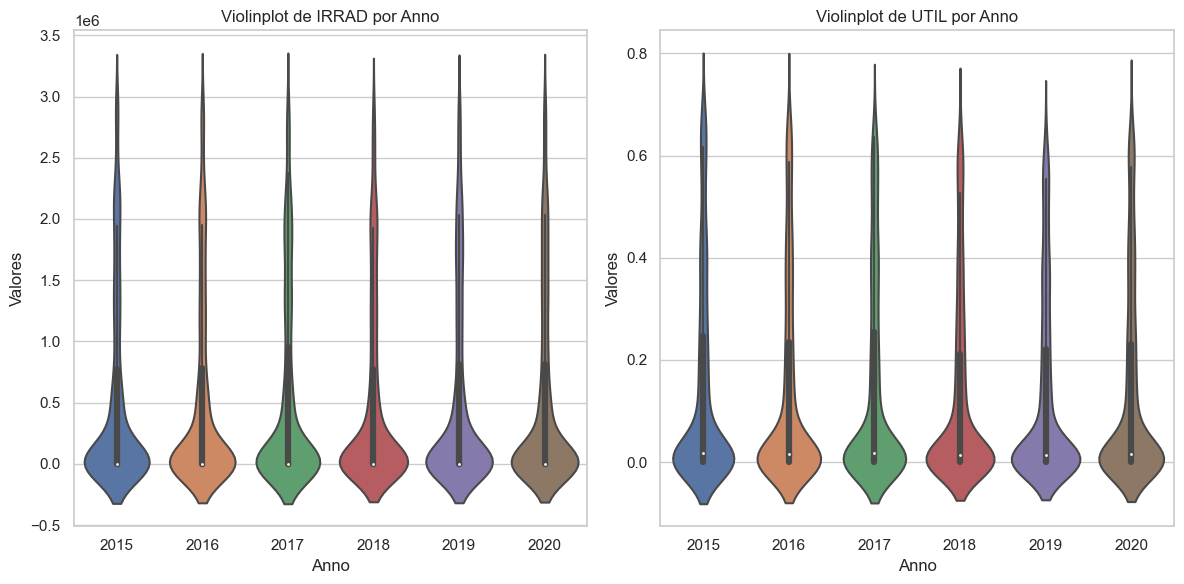

In [144]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='ANNO', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Anno')
    axs[col].set_xlabel('Anno')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

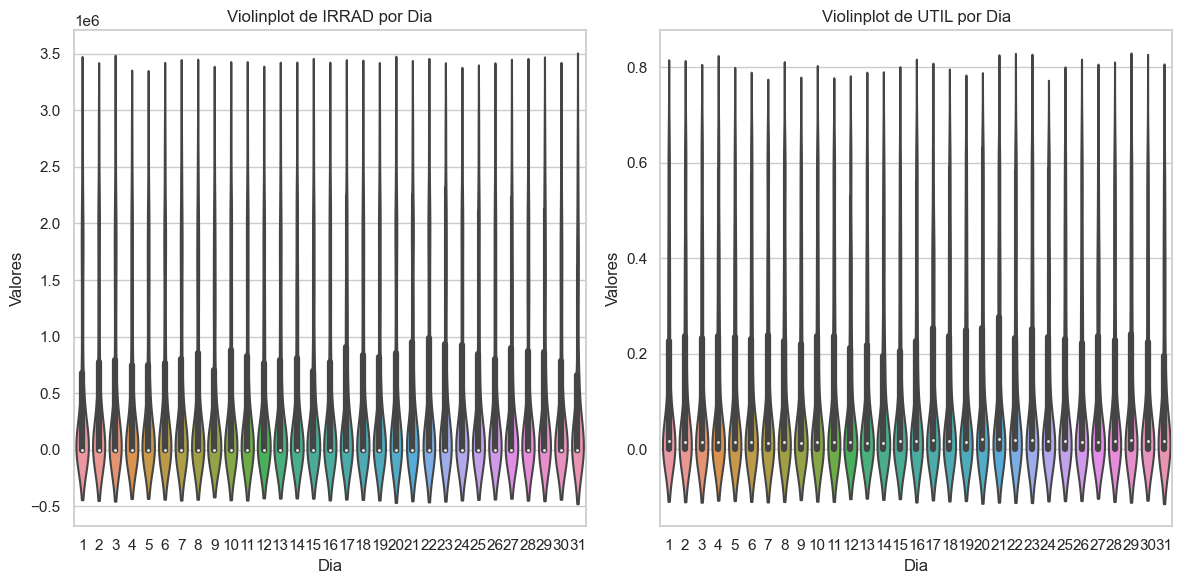

In [145]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='DIA', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Dia')
    axs[col].set_xlabel('Dia')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

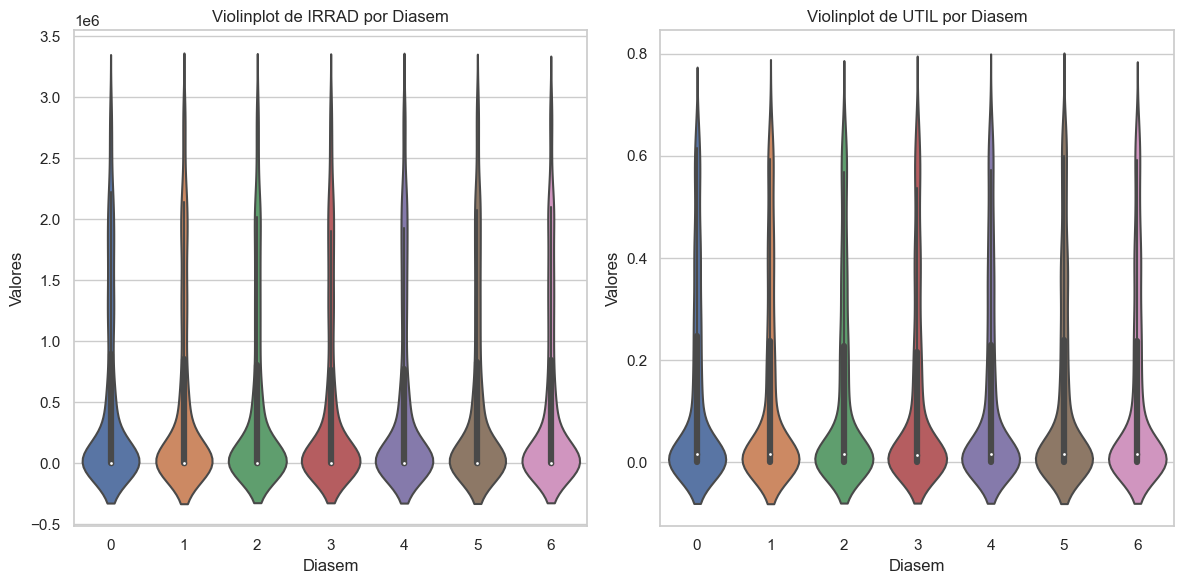

In [146]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='DIASEM', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Diasem')
    axs[col].set_xlabel('Diasem')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

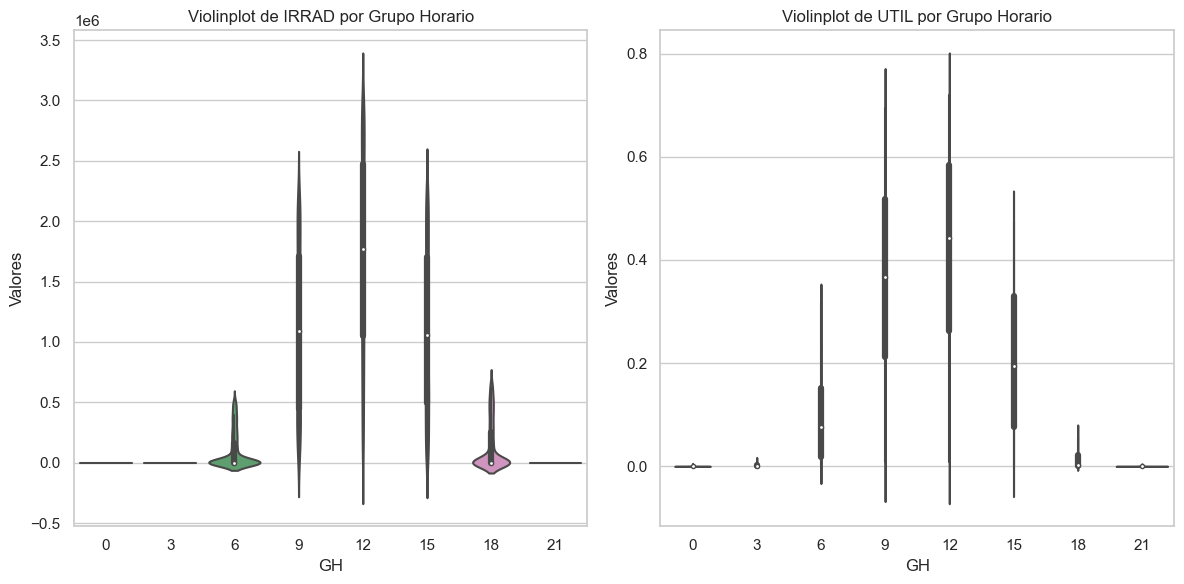

In [147]:
# Lista de variables en tu DataFrame
variables = df.columns

# Filtrar las variables que no son 'MES'
variables = [var for var in variables if not var in ['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM', 'GH']]

num_rows = len(variables) // 2  #Now there are 2 cuantitative variables
num_cols = 2

# Creation of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Loop in charge of representing histograms
for i, var in enumerate(variables):
    row = i // num_cols
    col = i % num_cols
    sns.violinplot(x='GH', y=var, data=df, ax=axs[col])
    axs[col].set_title(f'Violinplot de {var} por Grupo Horario')
    axs[col].set_xlabel('GH')
    axs[col].set_ylabel('Valores')

# Adjustment of design
plt.tight_layout()

# Graphic display
plt.show()

En efecto se comprueba que las únicas variables que parecen afectar a las utilizaciones son el mes, el grupo horario y las irradiaciones, tal y como se esperaba.

Por último, se comprueba como la relación entre la utilización en una hora determinada y su irradiación es lineal, junto a la diferencia en la relación según el mes y grupo horario.

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


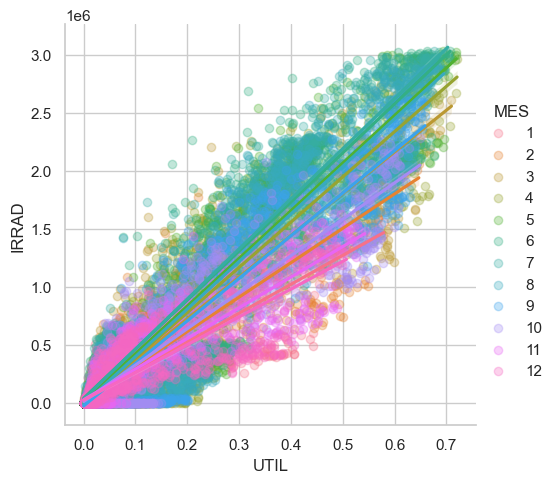

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


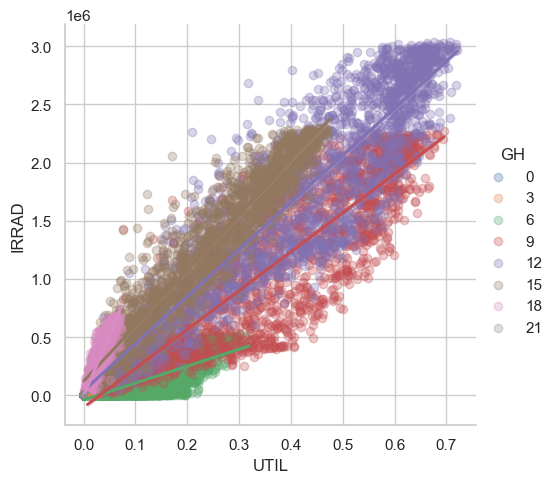

In [148]:
sns.lmplot(x='UTIL', y='IRRAD', hue='MES', data=df, scatter_kws={'alpha':0.3})
plt.show()
sns.lmplot(x='UTIL', y='IRRAD', hue='GH', data=df, scatter_kws={'alpha':0.3})
plt.show()

Esto demuestra la necesidad de que ambas variables se encuentren en cualquiera de los modelos a realizar (se puede ver la gran diferencia que hay entre el grupo horario 6, 18, 0, 3, 21 y 12, por ejemplo).

### 5. Desbalance de Clases

In [89]:
# Ya se ha comprobado anteriormente que no hay desbalances en las variables categóricas.

### 5. División del Dataset en Train y Test

En nuestro caso, dado que tenemos suficiente profundidad de datos (más de 17000), podemos realizar la siguiente división:

 + Train: **60%** de los datos. Ahí se encuentran también los datos de validación que se utilizan en k-fold cross validation para el grid search. Más de 10000 observaciones.

 + AdjTest: **20%** de los datos, llamados adjusting test. Sirven para comprobar los resultados de nuestros modelos, hacer pequeñas modificaciones y escoger el modelo que creamos que mejor predice y generaliza.

 + Test: **20%** de los datos. Éste conjunto a priori no lo tendríamos, por lo que debe estar guardado y no usarse hasta que no se tenga decidido el modelo final, el que nosotros creamos que es el mejor. Sirve únicamente para ver si estábamos en lo cierto, o en qué hemos fallado, pero una vez se mira el desempeño del modelo en este conjunto de datos, no se puede volver a tocar nada del modelo.

In [14]:
INPUTS = df.columns[df.columns != 'UTIL']
OUTPUT = 'UTIL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,  #percentage of test data
                                                    random_state=0) #seed for replication

# Split
X_AdjTest, X_Test, y_AdjTest, y_Test = train_test_split(X_test, y_test,
                                                    test_size=0.5,  #percentage of adjusting test data
                                                    random_state=0) #seed for replication

X_train.head()

,FECHA,ANNO,MES,DIA,DIASEM,GH,IRRAD
8264,2017-10-30,2017,10,30,0,0,0.0
6680,2017-04-15,2017,4,15,5,0,0.0
1326,2015-06-15,2015,6,15,0,18,526790.3
2187,2015-10-01,2015,10,1,3,9,1512109.1
2063,2015-09-15,2015,9,15,1,21,0.0


In [15]:
## Create dataset to store model predictions (as we said, the test dataset is not used anymore)
dfTR_eval = X_train.copy()
dfTR_eval['UTIL'] = y_train
dfTS_eval = X_AdjTest.copy()
dfTS_eval['UTIL'] = y_AdjTest

## PASO 2: ANÁLISIS PREVIO

Antes de proceder a la creación de diversos modelos utilizando técnicas de ensamblado, puede ser recomendable realizar un pequeño análisis con diversas técnicas como clustering, que nos podría ayudar a distinguir agrupaciones de los datos que se distribuyan o tengan una relación distinta, siendo necesaria la creación de modelos distintos para cada uno de esos clústers.

### 1. Clustering

In [218]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np
from scipy.cluster.vq import vq
from sklearn.mixture import GaussianMixture

# Other
from mltools import unsupervised_tools as UT

In [194]:
X_train_copy = X_train.copy()
X_train_copy = X_train_copy.iloc[:,1:]

# Seleccionar todas las columnas de tipo category
category_columns = X_train_copy.select_dtypes(include=['object', 'category']).columns.tolist()

# Crear las dummies
dummies_df = pd.get_dummies(X_train_copy[category_columns], drop_first=True)

In [200]:
# Convertir True/False a 0/1
dummies_df = dummies_df.astype(int)

# Crear una copia del DataFrame original sin las variables categóricas
X_train_copy = X_train.iloc[:,1:].drop(columns=category_columns)

# Concatenar las columnas dummy al DataFrame original
X_train_encoded = pd.concat([X_train_copy, dummies_df], axis=1)

In [202]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X=X_train_encoded)

#### Hierarchical

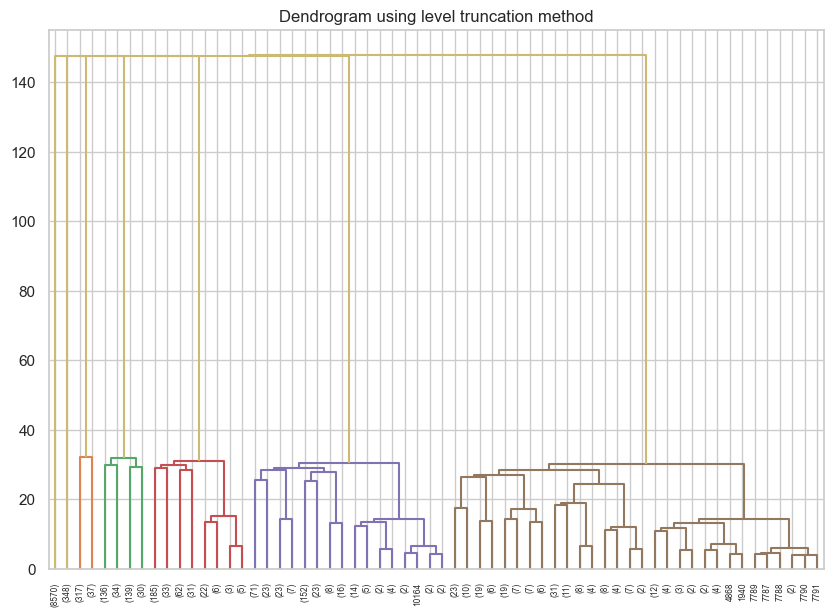

In [204]:
## Hierarchical clustering -------------------------------------------------------------------------------------------------------
# hierarchical clustering
linked = linkage(X_transformed, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=X_train_encoded.index,
            truncate_mode= 'level', # Type of truncation, in this case number of levels. A “level” includes all nodes with p merges from the last merge.
            p = 5, # Number of leaves to show
            above_threshold_color='y',
            color_threshold=100,
            distance_sort='descending',
            show_leaf_counts=True)
plt.gca().set_title('Dendrogram using level truncation method')
plt.show()

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The average silhouette_score is : 0.02749631291309363


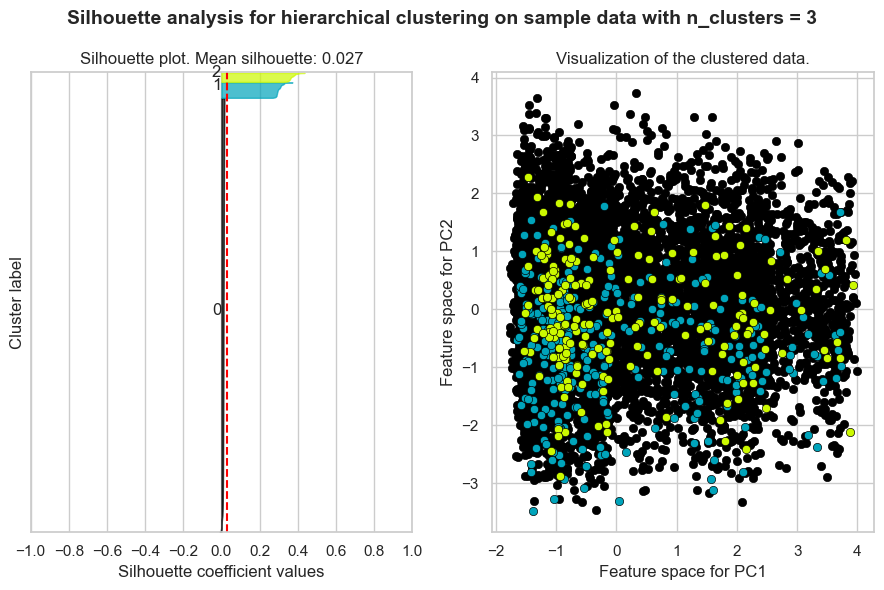

In [214]:
## Silhouette method ---------------
# Cut dendrogram tree by number of clusters
n_clusters = 3
cluster_labels = cut_tree(linked, n_clusters=n_clusters)
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X_transformed, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)

#Represent clusters
UT.plot_clusters(X_train_encoded, cluster_labels, alpha_curves=0.3, figsize=(9,6))

#### Kmeans

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to

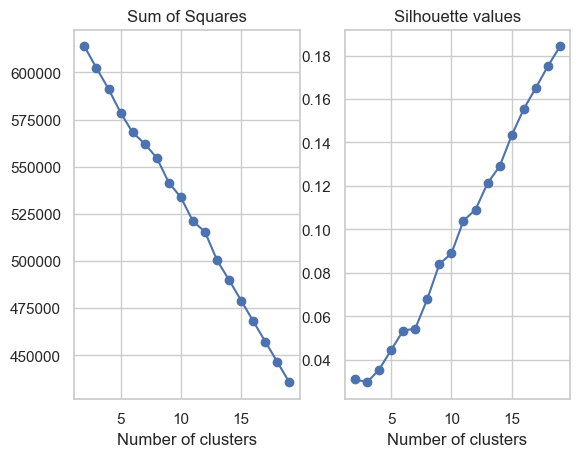

In [217]:
## K_means and silhouette method simultaneously with different number of clusters
range_n_clusters = list(range(2,20))
SSQ = []
sil_avg = []
plot = False
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_transformed)

    #Obtain Reconstruction error
    _ , err = vq(X_transformed, clusterer.cluster_centers_)
    SSQ.append(np.sum(err**2))
    #Obtain silhouette
    sil_avg.append(silhouette_score(X_transformed, cluster_labels))
    if plot:
        UT.plot_clusters(X_train_encoded, cluster_labels, centers=clusterer.cluster_centers_, figsize=(6,4))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range_n_clusters,SSQ, marker='o')
ax1.set_title("Sum of Squares")
ax1.set_xlabel("Number of clusters")
ax2.plot(range_n_clusters,sil_avg, marker='o')
ax2.set_title("Silhouette values")
ax2.set_xlabel("Number of clusters")
plt.show()

c:\Users\juanl\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clusters specifying number of clusters:
   # Samples
0       1338
1       5246
2       3937
The average silhouette_score is : 0.02957533976310426


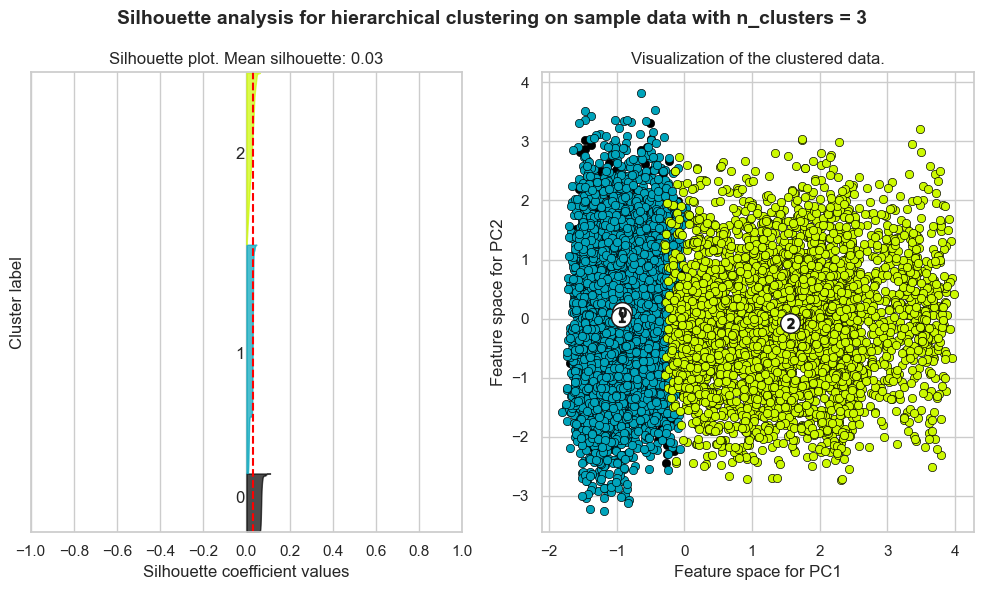

In [219]:
# Fit final model and validate
clusterer = KMeans(n_clusters=3, random_state=10)
#Predict on training dataset
cluster_knn = clusterer.fit_predict(X_transformed)
# Cut dendrogram tree by number of clusters
print('Clusters specifying number of clusters:')
unique, counts = np.unique(cluster_knn, return_counts=True)
print(pd.DataFrame(np.asarray(counts), index=unique, columns=['# Samples']))

# Silhouette
silhouette_avg = silhouette_score(X_transformed, cluster_knn)
print("The average silhouette_score is :", silhouette_avg)

# Plot clustering classification
UT.plot_clusters(X_train_encoded, cluster_knn, centers= scaler.inverse_transform(clusterer.cluster_centers_), figsize=(10,6))

#### Gaussian Mixture Models

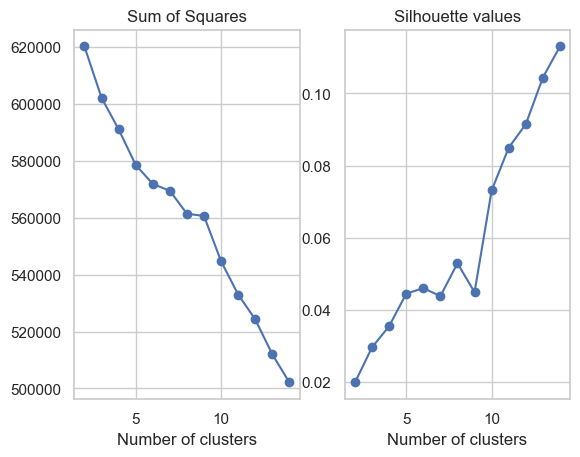

In [220]:
## K_means and silhouette method simultaneously with different number of clusters
range_n_clusters = list(range(2,15))
SSQ = []
sil_avg = []
cv_type = 'full'
for n_clusters in range_n_clusters:
    # fit model
    clusterer = GaussianMixture(n_components=n_clusters,
                              covariance_type=cv_type,
                              random_state=10)
    cluster_labels = clusterer.fit_predict(X_transformed)

    #Obtain Reconstruction error
    _ , err = vq(X_transformed, clusterer.means_)
    SSQ.append(np.sum(err**2))
    #Obtain silhouette
    sil_avg.append(silhouette_score(X_transformed, cluster_labels))
    if plot:
        UT.plot_clusters(X_train_encoded, cluster_labels, centers=clusterer.means_, figsize=(6,4))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range_n_clusters,SSQ, marker='o')
ax1.set_title("Sum of Squares")
ax1.set_xlabel("Number of clusters")
ax2.plot(range_n_clusters,sil_avg, marker='o')
ax2.set_title("Silhouette values")
ax2.set_xlabel("Number of clusters")
plt.show()

Clusters specifying number of clusters:
   # Samples
0       1338
1       5246
2       3937
The average silhouette_score is : 0.02957533976310426


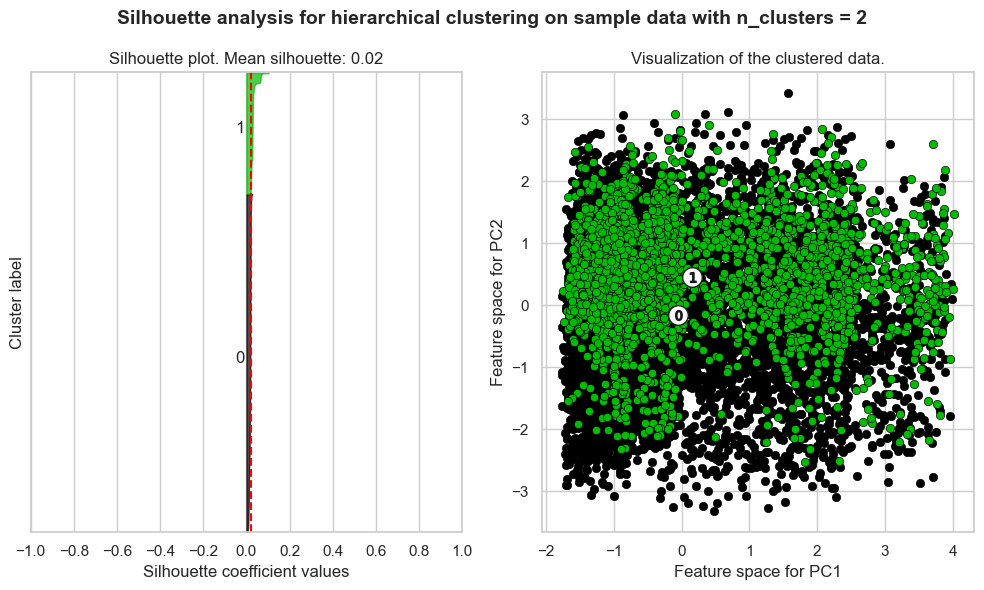

In [221]:
# Fit final model and validate
clusterer_GMM = GaussianMixture(n_components=2,
                              covariance_type='full',
                              random_state=10)
#Predict on training dataset
cluster_GMM = clusterer_GMM.fit_predict(X_transformed)
# Cut dendrogram tree by number of clusters
print('Clusters specifying number of clusters:')
unique, counts = np.unique(cluster_knn, return_counts=True)
print(pd.DataFrame(np.asarray(counts), index=unique, columns=['# Samples']))

# Silhouette
silhouette_avg = silhouette_score(X_transformed, cluster_knn)
print("The average silhouette_score is :", silhouette_avg)

# Plot clustering classification
UT.plot_clusters(X_train_encoded, cluster_GMM, centers= scaler.inverse_transform(clusterer_GMM.means_), figsize=(10,6))

Tras un ligero análisis no hay evidencias suficientes que nos indiquen que sea necesaria la división del conjunto de datos en clústers distintos, ya que todos los métodos consiguen resultados muy pobres desde las 2 hasta las 15 agrupaciones. Por tanto, se trabajará con el conjunto de datos de entrenamiento al completo para hacer un único modelo.

### 2. PDF

### 3. Bootstrap

### 4. Bagged trees and Randomforest

In [28]:
X_train.drop(columns=["FECHA"], inplace=True)
X_test.drop(columns=["FECHA"], inplace=True)

In [24]:
num_estimators = 50
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeRegressor( criterion='squared_error',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=10, # Minimum number of obs in a terminal node
                                                            random_state=999, # For replication
                                                            min_impurity_decrease=0.001))])

# Fit model
param = {'BT__n_estimators': range(20, 150, 5)} # Number of trees to aggregate

pipe =  Pipeline(steps=[('BT', 
                            BaggingRegressor(estimator=base_estimator,
                                              random_state=999))])

nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_absolute_error', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 

bt_fit.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingRegressor(estimator=Pipeline(steps=[('DT',
                                                                                    DecisionTreeRegressor(min_impurity_decrease=0.001,
                                                                                                          min_samples_leaf=10,
                                                                                                          random_state=999))]),
                                                         random_state=999))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)},
             scoring='neg_mean_absolute_error')

In [30]:
#predict
y_train_pred = bt_fit.predict(X_train)
y_test_pred = bt_fit.predict(X_test)

# Evaluate
train_error = np.mean(abs(y_train - y_train_pred))
test_error = np.mean(abs(y_test - y_test_pred))

print(f'Train error: {train_error}')
print(f'Test error: {test_error}')

Train error: 0.04612118733733067
Test error: 0.04734581297921485


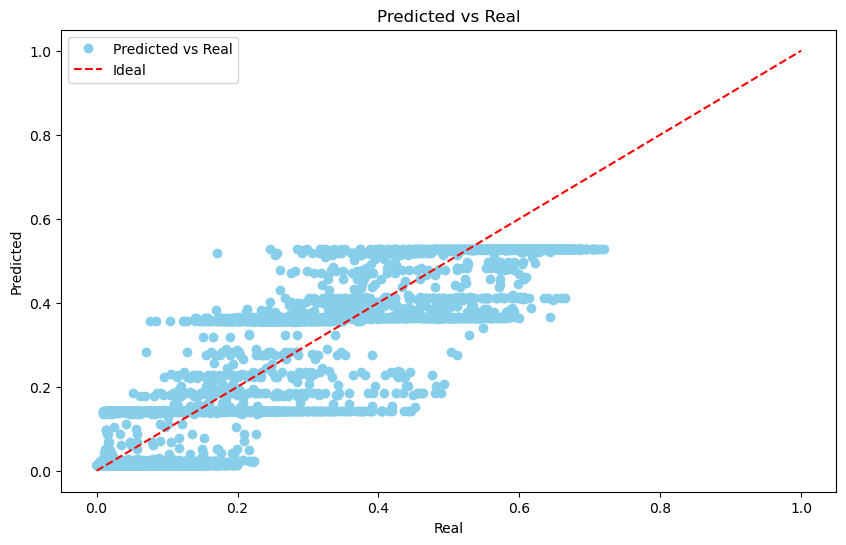

In [36]:
#plot results
plt.figure(figsize=(10, 6))
#dots in skyblue and edge in black
plt.plot(y_test, y_test_pred, 'o', label='Predicted vs Real', color="skyblue")
plt.plot([0, 1], [0, 1], 'r--', label='Ideal')
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('Predicted vs Real')
plt.legend()
plt.show()